In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb

import sys
sys.path.append('../')
from utils import *

In [2]:
is_kaggle = False

if is_kaggle:
    base_dir = '/kaggle/input'
    data_dir = f'{base_dir}/linking-writing-processes-to-writing-quality'
    output_dir = '/kaggle/working'
else:
    base_dir = '../'
    data_dir = f'{base_dir}/data'
    models_dir = f'{base_dir}/models'

In [8]:
train_logs_df = pd.read_csv(f'{data_dir}/train_logs.csv')
train_scores_df = pd.read_csv(f'{data_dir}/train_scores.csv')

test_logs_df = pd.read_csv(f'{data_dir}/test_logs.csv')

In [4]:
essayConstructor = EssayConstructor()
train_essays = essayConstructor.getEssays(train_logs_df)

100%|██████████| 2471/2471 [00:10<00:00, 242.87it/s]


In [5]:
train_essays.index = train_essays["id"]
train_essays.index.name = None
train_essays.drop(columns=["id"], inplace=True)
train_essays.head()

,essay
001519c8,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...
0022f953,"qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq..."
0042269b,qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...
0059420b,qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...
0075873a,"qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq..."


In [6]:
# Sentence features for train dataset
train_sent_df = split_essays_into_sentences(train_essays)
train_sent_agg_df = compute_sentence_aggregations(train_sent_df)

In [7]:
# Paragraph features for train dataset
train_paragraph_df = split_essays_into_paragraphs(train_essays)
train_paragraph_agg_df = compute_paragraph_aggregations(train_paragraph_df)

In [9]:
test_essays = essayConstructor.getEssays(test_logs_df)
test_sent_agg_df = compute_sentence_aggregations(split_essays_into_sentences(test_essays))
test_paragraph_agg_df = compute_paragraph_aggregations(split_essays_into_paragraphs(test_essays))

100%|██████████| 3/3 [00:00<00:00, 1499.93it/s]


In [11]:
preprocessor = Preprocessor(seed=42)
train_feats = preprocessor.make_feats(train_logs_df)
test_feats = preprocessor.make_feats(test_logs_df)
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
train_feats = train_feats.drop(columns=nan_cols)
test_feats = test_feats.drop(columns=nan_cols)

Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 33/33 [02:31<00:00,  4.58s/it, column=word_count_change100, method=kurt]         


Engineering activity counts data


100%|██████████| 2471/2471 [00:00<00:00, 7869.46it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering event counts data


100%|██████████| 2471/2471 [00:00<00:00, 7511.24it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 2471/2471 [00:00<00:00, 7544.57it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering text change counts data


100%|██████████| 2471/2471 [00:00<00:00, 7650.46it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering punctuation counts data


100%|██████████| 2471/2471 [00:00<00:00, 8519.24it/s]


Engineering input words data


c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:365: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:366: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:367: PerformanceWarning: DataFrame is highly fragmented.  This 

Engineering ratios data
Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 33/33 [00:01<00:00, 20.24it/s, column=word_count_change100, method=kurt]         


Engineering activity counts data


100%|██████████| 3/3 [00:00<00:00, 2999.50it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering event counts data


100%|██████████| 3/3 [00:00<?, ?it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 3/3 [00:00<?, ?it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering text change counts data


100%|██████████| 3/3 [00:00<00:00, 2994.51it/s]
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering punctuation counts data


100%|██████████| 3/3 [00:00<?, ?it/s]


Engineering input words data
Engineering ratios data


c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:365: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:366: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
c:\Users\luis.pinto1\Documents\GitHub\Linking-Writing\models\..\utils.py:367: PerformanceWarning: DataFrame is highly fragmented.  This 

In [12]:
train_agg_fe_df = train_logs_df.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(
    ['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
train_agg_fe_df.columns = ['_'.join(x) for x in train_agg_fe_df.columns]
train_agg_fe_df = train_agg_fe_df.add_prefix("tmp_")
train_agg_fe_df.reset_index(inplace=True)

test_agg_fe_df = test_logs_df.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(
    ['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
test_agg_fe_df.columns = ['_'.join(x) for x in test_agg_fe_df.columns]
test_agg_fe_df = test_agg_fe_df.add_prefix("tmp_")
test_agg_fe_df.reset_index(inplace=True)

train_feats = train_feats.merge(train_agg_fe_df, on='id', how='left')
test_feats = test_feats.merge(test_agg_fe_df, on='id', how='left')

In [13]:
# Idea is based on features introduced in Section 3 of this research paper: https://files.eric.ed.gov/fulltext/ED592674.pdf

data = []

for logs in [train_logs_df, test_logs_df]:
    logs['up_time_lagged'] = logs.groupby('id')['up_time'].shift(1).fillna(logs['down_time'])
    logs['time_diff'] = abs(logs['down_time'] - logs['up_time_lagged']) / 1000

    group = logs.groupby('id')['time_diff']
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    initial_pause = logs.groupby('id')['down_time'].first() / 1000
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    data.append(pd.DataFrame({
        'id': logs['id'].unique(),
        'largest_lantency': largest_lantency,
        'smallest_lantency': smallest_lantency,
        'median_lantency': median_lantency,
        'initial_pause': initial_pause,
        'pauses_half_sec': pauses_half_sec,
        'pauses_1_sec': pauses_1_sec,
        'pauses_1_half_sec': pauses_1_half_sec,
        'pauses_2_sec': pauses_2_sec,
        'pauses_3_sec': pauses_3_sec,
    }).reset_index(drop=True))

train_eD592674, test_eD592674 = data

train_feats = train_feats.merge(train_eD592674, on='id', how='left')
test_feats = test_feats.merge(test_eD592674, on='id', how='left')
train_feats = train_feats.merge(train_scores_df, on='id', how='left')

In [ ]:
# Adding the additional features to the original feature set

train_feats = train_feats.merge(train_sent_agg_df, on='id', how='left')
train_feats = train_feats.merge(train_paragraph_agg_df, on='id', how='left')
# test_feats = test_feats.merge(test_sent_agg_df, on='id', how='left')
# test_feats = test_feats.merge(test_paragraph_agg_df, on='id', how='left')

In [16]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [17]:
OOF_PREDS = np.zeros((len(train_feats), 2))
# TEST_PREDS = np.zeros((len(test_feats), 2))

In [25]:
models_dict = {}
scores = []
preds_dict = {}
count = 0
for _ in train_logs_df['id'].unique():
    preds_dict[count] = []
    count+=1

# test_predict_list = []
best_params = {'reg_alpha': 0.007678095440286993, 
               'reg_lambda': 0.34230534302168353, 
               'colsample_bytree': 0.627061253588415, 
               'subsample': 0.854942238828458, 
               'learning_rate': 0.04, 
               'num_leaves': 22, 
               'max_depth': 37, 
               'min_child_samples': 18,
               'n_jobs':4
              }

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_feats.shape[0])
    # X_test = test_feats[train_cols]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]
        params = {
            "objective": "regression",
            "metric": "rmse",
            'random_state': 42,
            "n_estimators" : 12001,
            "verbosity": -1,
            **best_params
        }
        model = lgb.LGBMRegressor(**params)
        early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
        
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  
                  callbacks=[early_stopping_callback],
        )

        valid_predict = model.predict(X_valid)

        for count, idx in enumerate(valid_idx):
            preds_dict[idx].append(valid_predict[count])

        oof_valid_preds[valid_idx] = valid_predict
        # OOF_PREDS[valid_idx, 0] += valid_predict / 5
        OOF_PREDS[valid_idx, 0] = valid_predict 


        # test_predict = model.predict(X_test)
        # TEST_PREDS[:, 0] += test_predict / 5 / 10
        # test_predict_list.append(test_predict)
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
    scores.append(oof_score)

In [27]:
means = []
stds = []

for idx in preds_dict:
    means.append(np.mean(preds_dict[idx]))
    stds.append(np.std(preds_dict[idx]))

In [34]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

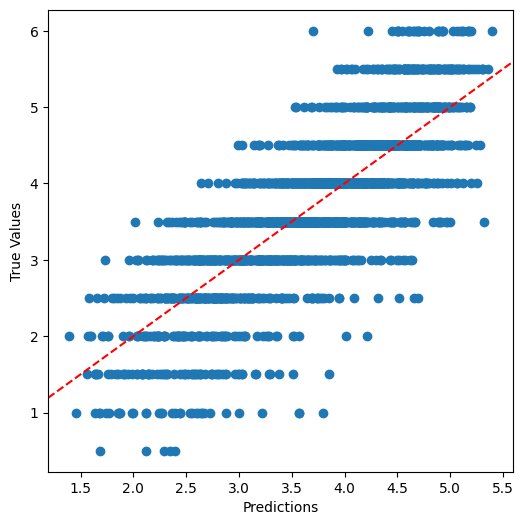

In [37]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(means, train_scores_df['score'])
add_identity(ax, color='r', ls='--')

plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()

In [33]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   means, 
                                                                   squared=False)))

OOF metric LGBM = 0.61498


In [31]:
train_scores_df

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0
...,...,...
2466,ffb8c745,3.5
2467,ffbef7e5,4.0
2468,ffccd6fd,1.5
2469,ffec5b38,5.0


(array([110., 496., 694., 545., 331., 177.,  72.,  32.,  12.,   2.]),
 array([0.00681443, 0.03011936, 0.05342429, 0.07672922, 0.10003415,
        0.12333908, 0.14664401, 0.16994894, 0.19325387, 0.21655881,
        0.23986374]),
 <BarContainer object of 10 artists>)

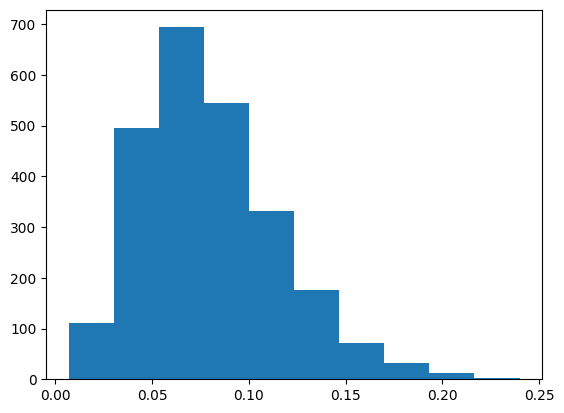

In [29]:
plt.hist(stds)

In [23]:
valid_predict[0]

3.144440776897315

In [20]:
X_valid

,event_id_max,up_time_max,action_time_max,action_time_min,action_time_mean,action_time_std,action_time_quantile,action_time_sem,action_time_sum,action_time_skew,...,paragraph_word_count_max,paragraph_word_count_first,paragraph_word_count_last,paragraph_word_count_sem,paragraph_word_count_q1,paragraph_word_count_median,paragraph_word_count_q3,paragraph_word_count_skew,paragraph_word_count_kurt,paragraph_word_count_sum
43,1697,1963166,153,0,62.227460,22.311583,68.0,0.541613,105600,-1.452049,...,85,41,64,12.599603,37.75,52.5,69.25,0.339968,-1.927633,218
44,5974,1718155,1357,0,77.431704,48.129123,74.0,0.622695,462577,11.455603,...,189,123,88,20.957795,114.25,130.0,150.00,0.577403,1.161610,537
56,1738,1781946,501,0,125.151323,46.945167,126.0,1.126072,217513,1.887814,...,82,72,73,3.179797,72.50,73.0,77.50,1.668034,NaN,227
93,3780,1802209,1591,0,66.564286,53.625798,67.0,0.872224,251613,17.538579,...,180,88,112,27.551971,100.00,112.0,146.00,1.252390,NaN,380
96,4239,1794771,509,0,85.688606,36.293378,86.0,0.557437,363234,0.512255,...,188,177,140,13.707510,138.00,158.5,179.75,0.064318,-4.818557,637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452,2659,1932004,1270,0,91.162843,30.676156,88.0,0.594897,242402,22.273709,...,135,62,45,13.096437,62.25,63.5,83.50,1.489808,2.231196,459
2457,2272,1800401,1237,0,94.985915,55.981360,94.0,1.174463,215808,8.565150,...,129,61,60,22.835158,60.50,61.0,95.00,1.730805,NaN,250
2468,3063,1959363,564,0,75.605615,63.494975,70.0,1.147271,231580,3.696536,...,1703,83,1703,543.873862,71.50,83.0,893.00,1.730889,NaN,1846
2469,3242,1508504,1388,0,89.277915,54.515788,85.0,0.957449,289439,9.407437,...,111,111,62,8.992219,66.00,85.0,93.00,0.350840,-1.192696,417


In [19]:
preds_dict

{'001519c8': [],
 '0022f953': [],
 '0042269b': [],
 '0059420b': [],
 '0075873a': [],
 '0081af50': [],
 '0093f095': [],
 '009e23ab': [],
 '00e048f1': [],
 '00e1f05a': [],
 '00e713bd': [],
 '00f0737e': [],
 '00f8e84c': [],
 '00fc9a6a': [],
 '0144e4d5': [],
 '014e7ae9': [],
 '015aa732': [],
 '0178a105': [],
 '0182aa1c': [],
 '0190ff4c': [],
 '01963e20': [],
 '019737b6': [],
 '01992d32': [],
 '01c359fc': [],
 '01d0ba4b': [],
 '01d602a7': [],
 '0249a095': [],
 '0262bf61': [],
 '026be946': [],
 '0294b4f5': [],
 '02a41d1a': [],
 '02cf6a52': [],
 '02d3c9fc': [],
 '02e86b6a': [],
 '031c0c58': [],
 '034d61db': [],
 '035f09fc': [],
 '036cfd42': [],
 '0395b217': [],
 '03971ddf': [],
 '040c429b': [],
 '0417d421': [],
 '0432f117': [],
 '0445b534': [],
 '044b274d': [],
 '044c5c54': [],
 '048fd254': [],
 '04b88b3e': [],
 '04c5f885': [],
 '04e37b6b': [],
 '04e63aec': [],
 '04f83ccb': [],
 '052a7811': [],
 '052b25e1': [],
 '052cf3a6': [],
 '053be4e5': [],
 '05624ab0': [],
 '056c41fc': [],
 '05b35fa0': [